In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import seaborn as sns

## Import Data

In [2]:
r_df = pd.read_excel('Raisin_Dataset.xlsx')
r_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


### We want binary response variable-> 0,1

In [3]:
class_encode = {
    "Kecimen": 0,
    "Besni": 1
}
r_df['Class'] = r_df['Class'].map(class_encode)
r_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,0
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,0
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,0
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,0
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,0


In [4]:
# Separate inputs: X and output:y
X = r_df.drop(['Class'], axis = 1)
y = r_df['Class']

In [5]:
# X, y = shuffle(X, y)
# y

In [6]:
# # Create the instance of the scaler
# scaler = StandardScaler()
# # Transform the inputs X
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train_scaled.std(axis=0)

In [7]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.001, 0.1, 20):
    for solver in ['liblinear','saga']:
        
        model = LogisticRegression(C=C, solver=solver,penalty='l1')
        accuracy = np.zeros(10)
        np_idx = 0
        
        Entropy_c = np.zeros(10)
        bias_c = np.zeros(10)
        variance_c = np.zeros(10)
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            ACC = accuracy_score(y_test, predictions, normalize = True)

            accuracy[np_idx] = ACC*100
            
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.011421052631578946, 'solver': 'liblinear'}
Best Score: 88.444%(7.523%)

The optimal log model uses C=0.011421052631578946, and a liblinear solver, and has a cross validation score of 88.444% with a standard deviation of 7.523%


In [9]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape

(630, 7)

In [10]:
# Create the instance of the scaler
scaler = StandardScaler()
# Transform the inputs X
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_scaled = scaler.transform(X)
# X_train_scaled.std(axis=0)

In [11]:
model = LogisticRegression(C=0.01, solver='liblinear',penalty='l1',max_iter=1000)
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)

### Confusion Matrix -- Grid Search

In [12]:
def create_cf(matrix):
  cf_matrix = matrix
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

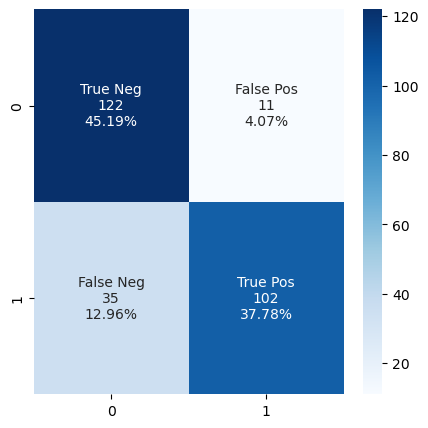

In [13]:
create_cf(confusion_matrix(y_test, predictions))

### ROC curve

In [14]:
#ROC curves
def roc_curves(X_train,X_test,y_train,y_test,LogReg):
    # Scores for train set
    scores_train = LogReg.predict_proba(X_train_scaled)[:, 1]
    # Scores for test set
    scores_test = LogReg.predict_proba(X_test_scaled)[:, 1]
    # ROC Calc Train set
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # AUC Calc
    auc_train = auc(fpr_train,tpr_train)
    # AUC Calc
    auc_test  = auc(fpr_test, tpr_test)

    # Plotting
    plt.plot(fpr_train,tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
    plt.plot(fpr_test,tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('Logistic Regression ROC curves', fontsize = 18)
    plt.ylabel('True positive rate', fontsize = 18)
    plt.xlabel('False positive rate', fontsize = 18)
    plt.legend()
    plt.show()

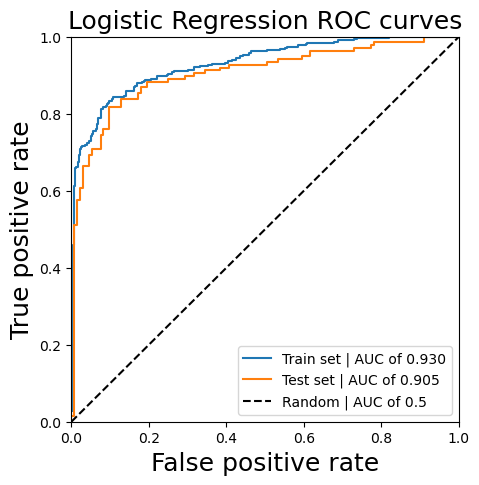

In [15]:
roc_curves(X_train_scaled,X_test_scaled,y_train,y_test,model)

### Learning curve

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/Users/tongfeili/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

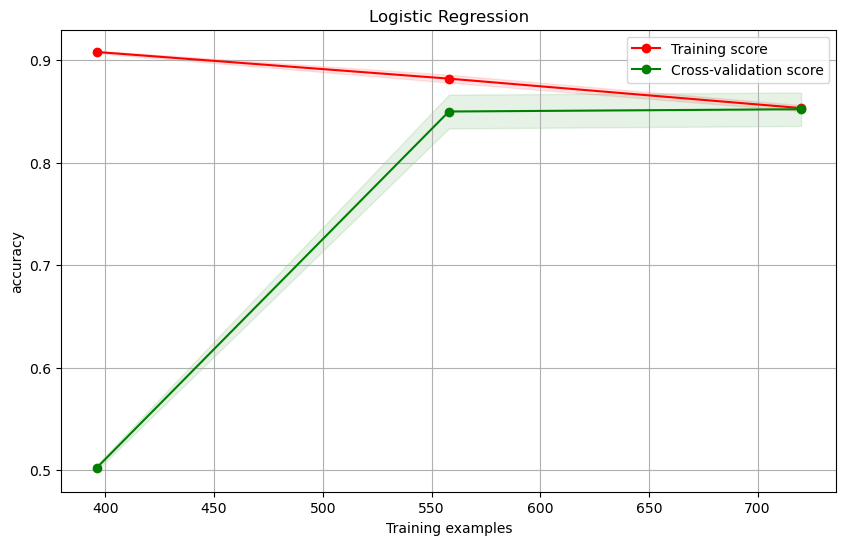

In [17]:
plot_learning_curve(model,'Logistic Regression', X_scaled, y, cv=5)

In [18]:
###### replace with Jason code #####

In [19]:
XX = pd.DataFrame(np.ones(900),columns=['intercept'])
X_in = pd.concat([XX,pd.DataFrame(X)], axis=1)
X_in

,intercept,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
0,1.0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040
1,1.0,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786
2,1.0,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575
3,1.0,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162
4,1.0,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251
...,...,...,...,...,...,...,...,...
895,1.0,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072
896,1.0,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252
897,1.0,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828
898,1.0,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548


## Model tunning
### Direct Method

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size=0.3, random_state=0)
X_train.shape

(630, 8)

In [21]:
# Create the instance of the scaler
scaler = StandardScaler()
# Transform the inputs X
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_scaled = scaler.transform(X_in)
# X_train_scaled.mean(axis=0)

In [22]:
import cvxpy as cp

beta = cp.Variable(8)
lambd = cp.Parameter(nonneg=True)
cost_function = cp.sum(
    cp.multiply(y_train, X_train_scaled.values @ beta) - cp.logistic(X_train_scaled.values @ beta)
)
problem = cp.Problem(cp.Minimize(-cost_function/810 + lambd * cp.norm(beta, 1)))

def acc(scores, labels):
    scores[scores > 0] = 1
    scores[scores <= 0] = 0
    return accuracy_score(labels, scores, normalize = True)
    
accc = np.zeros(50)
lambda_vals = np.logspace(-2, -1, 50)
beta_vals = []
for i in range(50):
    lambd.value = lambda_vals[i]
    problem.solve()
    accc[i] = acc((X_test_scaled.values @ beta).value, y_test)
    beta_vals.append(beta.value)

In [23]:
print('C value at highest accuracy:',lambda_vals[np.argmax(accc)])

C value at highest accuracy: 0.011513953993264475


In [24]:
print('Highest accuracy:',max(accc))

Highest accuracy: 0.8592592592592593


In [25]:
accc

array([0.85555556, 0.85555556, 0.85185185, 0.85925926, 0.85925926,
       0.85925926, 0.85925926, 0.85925926, 0.85925926, 0.85925926,
       0.85925926, 0.85925926, 0.85925926, 0.85925926, 0.85925926,
       0.85925926, 0.85925926, 0.85925926, 0.85925926, 0.85925926,
       0.85925926, 0.85925926, 0.85555556, 0.85555556, 0.85925926,
       0.85555556, 0.85185185, 0.85185185, 0.84444444, 0.83703704,
       0.83703704, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.82962963, 0.82962963, 0.82962963,
       0.82962963, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333])

### Confusion Matrix --  Direct Method

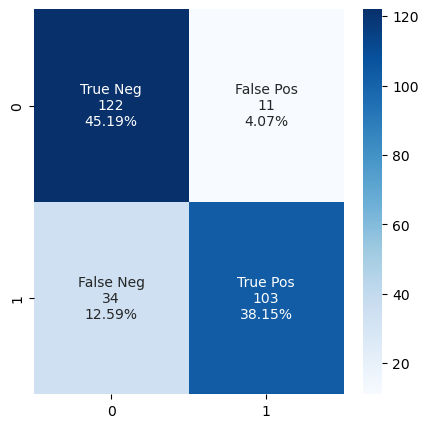

In [26]:
create_cf(confusion_matrix(y_test, ((X_test_scaled.values @ beta).value)>0))


## Bias Variance tradeoff and cross validation


### Bias Variance tradeoff with CV=10

In [27]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    for solver in ['liblinear','saga']:
        
        model = LogisticRegression(C=C, solver=solver,penalty='l1')
        accuracy = np.zeros(10)
        np_idx = 0
        
        Entropy_c = np.zeros(10)
        bias_c = np.zeros(10)
        variance_c = np.zeros(10)
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            ACC = accuracy_score(y_test, predictions, normalize = True)

            accuracy[np_idx] = ACC*100
            
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.0037241379310344828, 'solver': 'liblinear'}
Best Score: 89.889%(9.262%)

The optimal log model uses C=0.0037241379310344828, and a liblinear solver, and has a cross validation score of 89.889% with a standard deviation of 9.262%


In [28]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.0037241379310344828, 'solver': 'saga'}
Best Score: 89.889%(9.262%)

The optimal log model uses C=0.0037241379310344828, and a liblinear solver, and has a cross validation score of 89.889% with a standard deviation of 9.262%


In [29]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.0037241379310344828, 'solver': 'saga'}
Best Score: 89.889%(9.262%)

The optimal log model uses C=0.0037241379310344828, and a liblinear solver, and has a cross validation score of 89.889% with a standard deviation of 9.262%


### Bias Variance tradeoff CV = 10

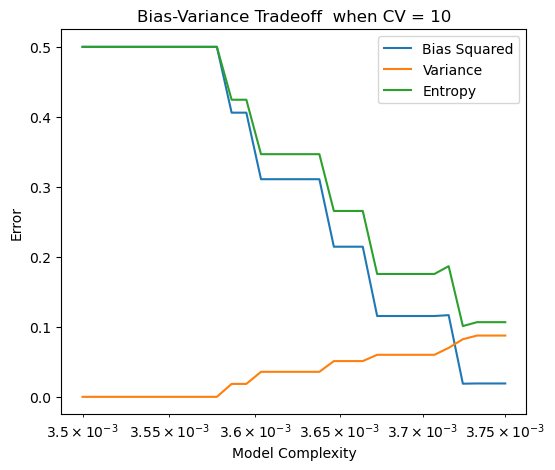

In [30]:
# Plot the bias-variance tradeoff for C graph. As model complexity increases, bias decrease and variances increase.
import seaborn as sns

fig = plt.figure(figsize=(6,5))
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], bias_list, label = 'Bias Squared')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], variance_list, label = 'Variance')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], Entropy_list, label = 'Entropy')
x_smooth = np.linspace(0.0035, 0.00375, 30)
x = np.linspace(0.0035, 0.00375, 30)
bias_smooth = np.interp(x_smooth, x, bias_list)
var_smooth = np.interp(x_smooth, x,variance_list)
Entropy_smooth = np.interp(x_smooth, x,Entropy_list)
plt.semilogx(x_smooth, bias_smooth, label = 'Bias Squared')
plt.semilogx(x_smooth, var_smooth, label = 'Variance')
plt.semilogx(x_smooth, Entropy_smooth, label = 'Entropy')
plt.xlabel("Model Complexity")
plt.title("Bias-Variance Tradeoff  when CV = 10")
plt.ylabel("Error")
plt.legend(fontsize = 10)
plt.xticks(rotation=45)
plt.show()

## Model tunning
### Grid search - sklearn CV = 20

In [31]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=15)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    for solver in ['liblinear','saga']:
        
        model = LogisticRegression(C=C, solver=solver,penalty='l1')
        accuracy = np.zeros(15)
        np_idx = 0
        
        Entropy_c = np.zeros(15)
        bias_c = np.zeros(15)
        variance_c = np.zeros(15)
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            ACC = accuracy_score(y_test, predictions, normalize = True)

            accuracy[np_idx] = ACC*100
            
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.0035775862068965518, 'solver': 'liblinear'}
Best Score: 88.889%(10.141%)

The optimal log model uses C=0.0035775862068965518, and a liblinear solver, and has a cross validation score of 88.889% with a standard deviation of 10.141%


In [32]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=15)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.0035775862068965518, 'solver': 'saga'}
Best Score: 88.889%(10.141%)

The optimal log model uses C=0.0035775862068965518, and a liblinear solver, and has a cross validation score of 88.889% with a standard deviation of 10.141%


In [33]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=15)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.0035775862068965518, 'solver': 'saga'}
Best Score: 88.889%(10.141%)

The optimal log model uses C=0.0035775862068965518, and a liblinear solver, and has a cross validation score of 88.889% with a standard deviation of 10.141%


### Bias Variance tradeoff CV = 15

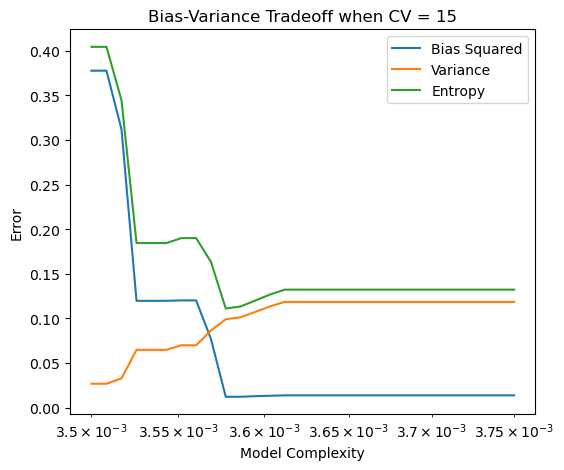

In [34]:
# Plot the bias-variance tradeoff for C graph. As model complexity increases, bias decrease and variances increase.
import seaborn as sns

fig = plt.figure(figsize=(6,5))
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], bias_list, label = 'Bias Squared')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], variance_list, label = 'Variance')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], Entropy_list, label = 'Entropy')
x_smooth = np.linspace(0.0035, 0.00375, 30)
x = np.linspace(0.0035, 0.00375, 30)
bias_smooth = np.interp(x_smooth, x, bias_list)
var_smooth = np.interp(x_smooth, x,variance_list)
Entropy_smooth = np.interp(x_smooth, x,Entropy_list)
plt.semilogx(x_smooth, bias_smooth, label = 'Bias Squared')
plt.semilogx(x_smooth, var_smooth, label = 'Variance')
plt.semilogx(x_smooth, Entropy_smooth, label = 'Entropy')
plt.xlabel("Model Complexity")
plt.title("Bias-Variance Tradeoff when CV = 15")
plt.ylabel("Error")
plt.legend(fontsize = 10)
plt.xticks(rotation=45)
plt.show()

## Model tunning
### Grid search - sklearn CV = 8

In [35]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=8)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    for solver in ['liblinear','saga']:
        
        model = LogisticRegression(C=C, solver=solver,penalty='l1')
        accuracy = np.zeros(20)
        np_idx = 0
        
        Entropy_c = np.zeros(8)
        bias_c = np.zeros(8)
        variance_c = np.zeros(8)
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            ACC = accuracy_score(y_test, predictions, normalize = True)

            accuracy[np_idx] = ACC*100
            
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.003732758620689655, 'solver': 'liblinear'}
Best Score: 27.813%(42.819%)

The optimal log model uses C=0.003732758620689655, and a liblinear solver, and has a cross validation score of 27.813% with a standard deviation of 42.819%


In [36]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=8)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.003732758620689655, 'solver': 'saga'}
Best Score: 69.533%(41.02%)

The optimal log model uses C=0.003732758620689655, and a liblinear solver, and has a cross validation score of 69.533% with a standard deviation of 41.02%


In [37]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=8)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

bias_list = [] 
variance_list = [] 
Entropy_list = []

for C in np.linspace(0.0035, 0.00375, 30):
    model = LogisticRegression(C=C, solver='liblinear',penalty='l1')
    np_idx = 0
        
    accuracy = []
    m = []
    b = []
    v = []
        
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        ACC = accuracy_score(y_test, predictions, normalize = True)

        accuracy.append(ACC*100)
        
        m.append(log_loss(y_test,predictions)) 
        v.append(np.var(predictions)) 
        b.append(np.mean((y_test - predictions) ** 2) - np.var(predictions))
            
        np_idx += 1
            
        
    bias_list.append(np.mean(b)) 
    variance_list.append(np.mean(v))
    Entropy_list.append(np.mean(m))
        
    if np.mean(accuracy) > best_accuracy:
        best_model = model
        best_params = {'C':C, 'solver':solver}
        best_accuracy = np.mean(accuracy)
        best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],'liblinear',round(best_accuracy,3),round(best_std,3)))

{'C': 0.003732758620689655, 'solver': 'saga'}
Best Score: 69.533%(41.02%)

The optimal log model uses C=0.003732758620689655, and a liblinear solver, and has a cross validation score of 69.533% with a standard deviation of 41.02%


### Bias Variance tradeoff CV = 8

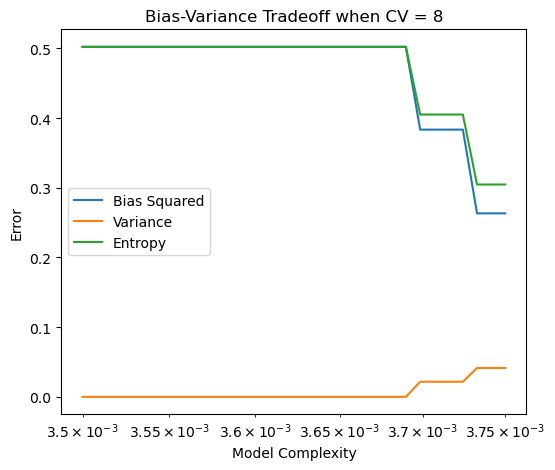

In [38]:
# Plot the bias-variance tradeoff for C graph. As model complexity increases, bias decrease and variances increase.
import seaborn as sns

fig = plt.figure(figsize=(6,5))
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], bias_list, label = 'Bias Squared')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], variance_list, label = 'Variance')
# plt.semilogx([0.0035,0.005,0.007,0.01,0.03, 0.05,0.07,0.1,0.5,1], Entropy_list, label = 'Entropy')
x_smooth = np.linspace(0.0035, 0.00375, 30)
x = np.linspace(0.0035, 0.00375, 30)
bias_smooth = np.interp(x_smooth, x, bias_list)
var_smooth = np.interp(x_smooth, x,variance_list)
Entropy_smooth = np.interp(x_smooth, x,Entropy_list)
plt.semilogx(x_smooth, bias_smooth, label = 'Bias Squared')
plt.semilogx(x_smooth, var_smooth, label = 'Variance')
plt.semilogx(x_smooth, Entropy_smooth, label = 'Entropy')
plt.xlabel("Model Complexity")
plt.title("Bias-Variance Tradeoff when CV = 8")
plt.ylabel("Error")
plt.legend(fontsize = 10)
plt.xticks(rotation=45)
plt.show()